**Contributors: Anirudh Gaur, Pradeep Kumar G**

Ignore next 4 if not run from colab..

In [2]:
from google.colab import drive
drive.mount('/content/drive') ## Mount

Mounted at /content/drive


In [3]:
import os 
os.chdir('/content/drive/MyDrive/EED363AML') ## directory of folder

In [ ]:
!mkdir data

In [ ]:
!mv /content/drive/MyDrive/EED363AML/online_shoppers_intention.csv data/

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
#import shap
import plotly.graph_objs as go
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras as k

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
Provide Data Path HERE

In [5]:
##folder 
data_path = "data/online_shoppers_intention.csv"

In [6]:
df = pd.read_csv(data_path)
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [6]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [ ]:
df.OperatingSystems.unique()


array([1, 2, 4, 3, 7, 6, 8, 5])

In [ ]:
df.Revenue.value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

In [ ]:
df.shape

(12330, 18)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [ ]:
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [7]:
data = df.copy()

In [8]:
#Conversion to Numerical format
data['Revenue'] = data['Revenue'].astype(int)
data['Weekend'] = data['Weekend'].astype(int)


In [9]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,1,0


In [9]:

# Assigning numbers to Months
temp_data = data.copy()
month_map={'Feb':2,'Mar':3,'May':5,'June':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
temp_data['Month']=temp_data['Month'].map(month_map)

#Assigning numbers to Visitor Type
vistor_map={'New_Visitor':0,'Returning_Visitor':1,'Other':2}
temp_data['VisitorType']=temp_data['VisitorType'].map(vistor_map)
temp_data['Weekend'] = temp_data['Weekend'].astype(int)

In [10]:
temp_data.Month.unique()

array([ 2,  3,  5, 10,  6,  7,  8, 11,  9, 12])

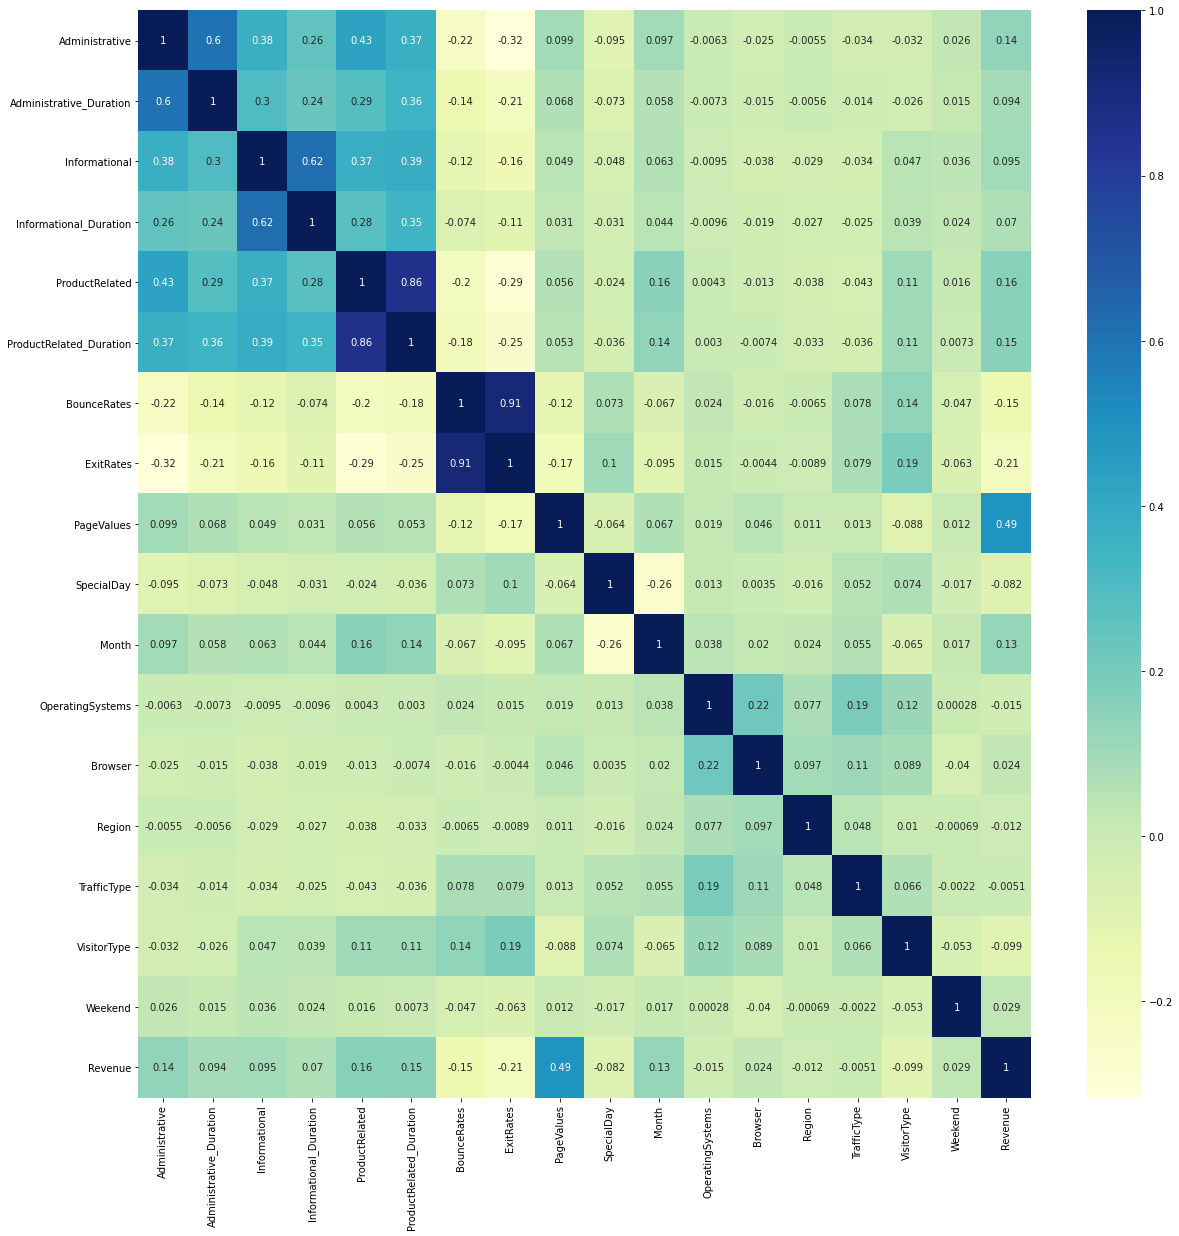

In [12]:
# Correlations between features.

correlations=temp_data.corr()
correlations

plt.figure(figsize=(20,20))
sns.heatmap(correlations,xticklabels=correlations.columns,
            yticklabels=correlations.columns,annot=True, cmap="YlGnBu")

In [11]:
def train_test(dataset, testSize, attrib='Revenue'):
  
  X = dataset.drop([attrib], axis=1)
  y = dataset[attrib]

  return train_test_split(X, y, test_size = testSize, random_state=12)


In [12]:
## Imbalanced Data Technique 

## SMOTE - Synthetic Minority Oversampling TEchnique
def smote_data(X_train, y_train):
  smt = SMOTE()
  return smt.fit_sample(X_train, y_train)

In [13]:
## Evaluation
def evaluate_model(y_test, y_pred):

  acc = accuracy_score(y_test, y_pred)
  print('Testing Accuracy : ', acc)

  # classification report
  cr = classification_report(y_test, y_pred)
  print('Classification Report :')
  print(cr)

  cm = confusion_matrix(y_test, y_pred)
  print(cm)
  TP, FN, FP, TN = cm[1][1], cm[1][0], cm[0][1],cm[0][0]

  # true positive rate
  TPR = TP/(TP+FN)
  # true negative rate
  TNR = TN/(TN+FP) 
  
  # false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)

  print('Sensitivity/tp_rate = ', TPR)
  print('Specificity/tn_rate = ', TNR)
  print('fp rate = ',FPR)
  print('fn rate = ',FNR)

  # confusion matrix
  
  print('Confusion Matrix :')
  
  plt.rcParams['figure.figsize'] = (6, 6)
  sns.heatmap(cm ,annot = True)

  return TPR, TNR, FPR, FNR

Total Models:

Normal:
Naive Bayes, Logistic Regression, Random Forest, SVM, Decision Tree, Adaboost, Neural Network

Imbalanace:Naive Bayes, Logistic Regression, Random Forest, SVM, Decision Tree, Adaboost, Neural Network

Standardized w/Feature Selection: Naive Bayes, Logistic Regression, Random Forest, SVM, Adaboost, Decision Tree, Neural Network

Combined:


Normal Train Test Split models..

In [45]:
#X_train, X_test, y_train, y_test = train_test(temp_data, 0.3)
X_train, X_test, y_train, y_test = train_test(temp_data, 0.2)

In [46]:
##Standardizing data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

xsc_train = sc.fit_transform(X_train)
xsc_test = sc.fit_transform(X_test)

Testing Accuracy :  0.7964314679643146
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      2084
           1       0.41      0.71      0.52       382

    accuracy                           0.80      2466
   macro avg       0.67      0.76      0.70      2466
weighted avg       0.86      0.80      0.82      2466

[[1692  392]
 [ 110  272]]
Sensitivity/tp_rate =  0.7120418848167539
Specificity/tn_rate =  0.8119001919385797
fp rate =  0.18809980806142035
fn rate =  0.2879581151832461
Confusion Matrix :


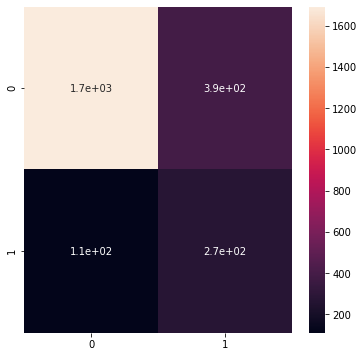

In [52]:
##Naive Bayes with normalized data
models = []

gnb = GaussianNB()

#x, y = smote_data(X_train, y_train)

y_pred = gnb.fit(xsc_train, y_train).predict(xsc_test)

models.append({'model' : gnb, 'label': 'Naive Bayes', 'x_test': xsc_test, 'y_test': y_test})


TPR, TNR, FPR, FNR = evaluate_model(y_test, y_pred)

Testing Accuracy :  0.851581508515815
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      3114
           1       0.53      0.56      0.54       585

    accuracy                           0.85      3699
   macro avg       0.72      0.73      0.73      3699
weighted avg       0.85      0.85      0.85      3699

[[2824  290]
 [ 259  326]]
Sensitivity/tp_rate =  0.5572649572649573
Specificity/tn_rate =  0.9068721901091843
fp rate =  0.09312780989081568
fn rate =  0.4427350427350427
Confusion Matrix :


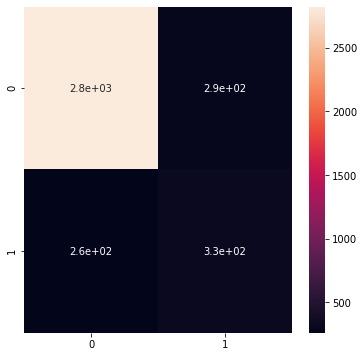

In [46]:
models = []
## NAIVE BAYES
gnb = GaussianNB()

#x, y = smote_data(X_train, y_train)

y_pred = gnb.fit(X_train, y_train).predict(X_test)



TPR, TNR, FPR, FNR = evaluate_model(y_test, y_pred)

models.append({'model' : gnb, 'label': 'Naive Bayes', 'x_test': X_test, 'y_test': y_test, 'TPR': TPR, 'TNR':TNR,'FPR': FPR,'FNR': FNR})

In [48]:
models

[{'label': 'Naive Bayes',
  'model': GaussianNB(priors=None, var_smoothing=1e-09),
  'x_test':        Administrative  Administrative_Duration  ...  VisitorType  Weekend
  7949                0                      0.0  ...            1        0
  4113                0                      0.0  ...            1        0
  351                 0                      0.0  ...            1        0
  4310                0                      0.0  ...            1        1
  1598                0                      0.0  ...            1        0
  ...               ...                      ...  ...          ...      ...
  2841                0                      0.0  ...            1        0
  11718               0                      0.0  ...            1        0
  11695               5                     29.0  ...            1        0
  6830                0                      0.0  ...            1        0
  424                 4                     74.0  ...            1     

Shape of x_train: (9864, 17)
Shape of x_test : (2466, 17)
Testing Accuracy :  0.8856447688564477
Classification Report :
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2084
           1       0.75      0.40      0.52       382

    accuracy                           0.89      2466
   macro avg       0.82      0.69      0.73      2466
weighted avg       0.87      0.89      0.87      2466

[[2033   51]
 [ 231  151]]
Sensitivity/tp_rate =  0.39528795811518325
Specificity/tn_rate =  0.97552783109405
fp rate =  0.024472168905950095
fn rate =  0.6047120418848168
Confusion Matrix :


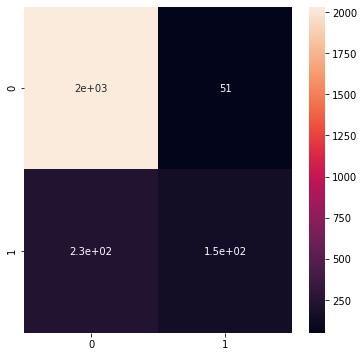

In [53]:
# Logisitic Regression With normal split data

# Split data

#x_train, x_test, y_train, y_test = split_data(temp_data, 0.3)

print("Shape of x_train:", X_train.shape)
print("Shape of x_test :", X_test.shape)


#x_train, x_test, y_train, y_test = split_data(temp_data, 0.3)

model = LogisticRegression(max_iter=4000)

#x, y = smote_data(x_train, y_train)

model.fit(xsc_train,y_train)

y_pred = model.predict(xsc_test)

models.append({'model' : model, 'label': 'Logistic Regression', 'x_test': xsc_test, 'y_test': y_test})

TPR, TNR, FPR, FNR = evaluate_model(y_test, y_pred)

#models.append({'model' : model, 'label': 'Logistic Regression', 'x_test': X_test, 'y_test': y_test, 'TPR': TPR, 'TNR':TNR,'FPR': FPR,'FNR': FNR})


In [ ]:
models

Testing Accuracy :  0.843065693430657
Classification Report :
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2084
           1       0.49      0.45      0.47       382

    accuracy                           0.84      2466
   macro avg       0.70      0.68      0.69      2466
weighted avg       0.84      0.84      0.84      2466

[[1908  176]
 [ 211  171]]
Sensitivity/tp_rate =  0.4476439790575916
Specificity/tn_rate =  0.9155470249520153
fp rate =  0.08445297504798464
fn rate =  0.5523560209424084
Confusion Matrix :


(0.4476439790575916,
 0.9155470249520153,
 0.08445297504798464,
 0.5523560209424084)

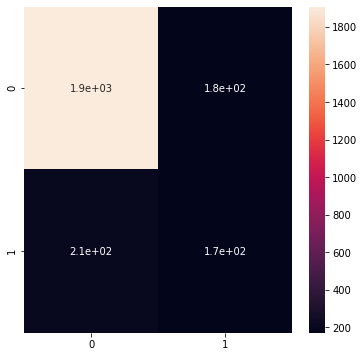

In [54]:
## Decision Tree With Normal Data

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(xsc_train, y_train)

y_pred = model.predict(xsc_test)

#print('Training Accuracy : ', model.score(xsc_train, y_train))

models.append({'model' : model, 'label': 'Decision Tree', 'x_test': xsc_test, 'y_test': y_test})

evaluate_model(y_test, y_pred)

Training Accuracy :  1.0
Testing Accuracy :  0.8588807785888077
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3114
           1       0.55      0.57      0.56       585

    accuracy                           0.86      3699
   macro avg       0.74      0.74      0.74      3699
weighted avg       0.86      0.86      0.86      3699

Sensitivity/tp_rate =  0.5675213675213675
Specificity/tn_rate =  0.9136159280667951
fp rate =  0.08638407193320488
fn rate =  0.4324786324786325
Confusion Matrix :


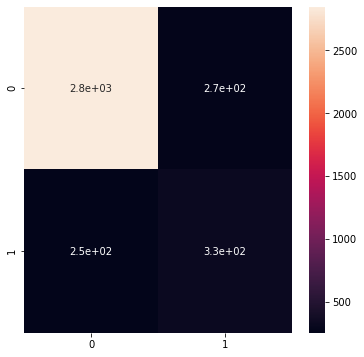

In [ ]:
## Decision Tree With Normal Data

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Training Accuracy : ', model.score(X_train, y_train))

evaluate_model(y_test, y_pred)

Shape of x_train: (9864, 17)
Shape of x_test : (2466, 17)
Testing Accuracy :  0.9047039740470397
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2084
           1       0.75      0.58      0.65       382

    accuracy                           0.90      2466
   macro avg       0.84      0.77      0.80      2466
weighted avg       0.90      0.90      0.90      2466

[[2010   74]
 [ 161  221]]
Sensitivity/tp_rate =  0.5785340314136126
Specificity/tn_rate =  0.9644913627639156
fp rate =  0.03550863723608445
fn rate =  0.4214659685863874
Confusion Matrix :


(0.5785340314136126,
 0.9644913627639156,
 0.03550863723608445,
 0.4214659685863874)

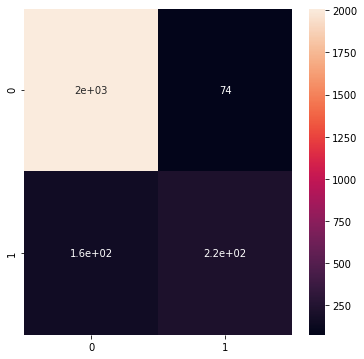

In [55]:
# RandomForest with normal train test data


#X_train, X_test, y_train, y_test = train_test(temp_data, 0.3)

print("Shape of x_train:", X_train.shape)
print("Shape of x_test :", X_test.shape)


model = RandomForestClassifier()

model.fit(xsc_train, y_train)

y_pred = model.predict(xsc_test)

models.append({'model' : model, 'label': 'Random Forest', 'x_test': xsc_test, 'y_test': y_test})


evaluate_model(y_test, y_pred)

Shape of x_train: (8631, 17)
Shape of x_test : (3699, 17)
Accuracy :  0.903757772370911
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3114
           1       0.76      0.57      0.65       585

    accuracy                           0.90      3699
   macro avg       0.84      0.77      0.80      3699
weighted avg       0.90      0.90      0.90      3699

Confusion Matrix :


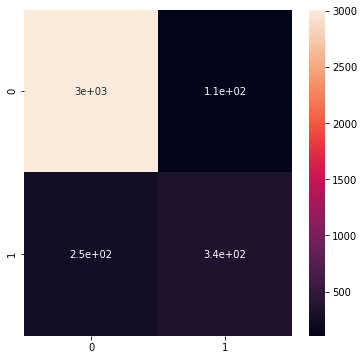

In [ ]:
# RandomForest with normal train test data


X_train, X_test, y_train, y_test = train_test(temp_data, 0.3)

print("Shape of x_train:", X_train.shape)
print("Shape of x_test :", X_test.shape)


model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Testing Accuracy : ', model.score(X_train, y_train))

evaluate_model(y_test, y_pred)

Testing Accuracy :  0.9075425790754258
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2084
           1       0.74      0.62      0.67       382

    accuracy                           0.91      2466
   macro avg       0.84      0.79      0.81      2466
weighted avg       0.90      0.91      0.90      2466

[[2002   82]
 [ 146  236]]
Sensitivity/tp_rate =  0.6178010471204188
Specificity/tn_rate =  0.9606525911708254
fp rate =  0.03934740882917467
fn rate =  0.38219895287958117
Confusion Matrix :


(0.6178010471204188,
 0.9606525911708254,
 0.03934740882917467,
 0.38219895287958117)

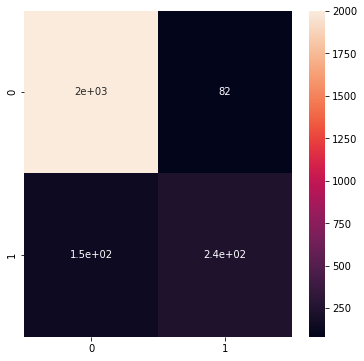

In [56]:
## XGBoost with Normal Data
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = XGBClassifier()

model.fit(xsc_train, y_train)

models.append({'model' : model, 'label': 'XGBoost', 'x_test': xsc_test, 'y_test': y_test})


y_pred = model.predict(xsc_test)
evaluate_model(y_test, y_pred)

Training Accuracy :  0.916463909164639
Testing Accuracy :  0.9099756690997567
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      3114
           1       0.77      0.62      0.68       585

    accuracy                           0.91      3699
   macro avg       0.85      0.79      0.82      3699
weighted avg       0.90      0.91      0.91      3699

Sensitivity/tp_rate =  0.6170940170940171
Specificity/tn_rate =  0.9649967886962106
fp rate =  0.03500321130378934
fn rate =  0.38290598290598293
Confusion Matrix :


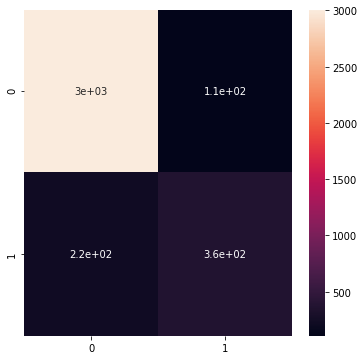

In [ ]:
## XGBoost with Normal Data
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = XGBClassifier()

model.fit(X_train, y_train)

print('Training Accuracy : ', model.score(X_train, y_train))

y_pred = model.predict(X_test)
evaluate_model(y_test, y_pred)

In [57]:
##NEURAL NETWORK with normalized data

model = k.Sequential([
    k.layers.Dense(60, input_shape=(xsc_train.shape[1],), activation=tf.nn.relu),
    k.layers.Dense(units=1, activation=tf.nn.sigmoid)
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 60)                1080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


Testing Accuracy :  0.8982157339821574
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2084
           1       0.71      0.57      0.63       382

    accuracy                           0.90      2466
   macro avg       0.82      0.76      0.79      2466
weighted avg       0.89      0.90      0.89      2466

[[1997   87]
 [ 164  218]]
Sensitivity/tp_rate =  0.5706806282722513
Specificity/tn_rate =  0.958253358925144
fp rate =  0.041746641074856046
fn rate =  0.4293193717277487
Confusion Matrix :
Confusion Matrix :
78/78 [==============================] - 0s 891us/step - loss: 0.2591 - accuracy: 0.8982


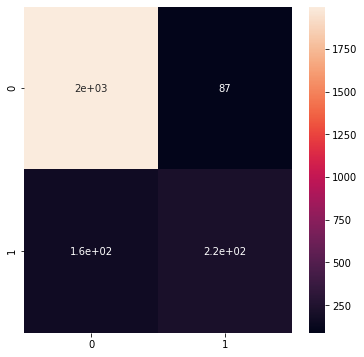

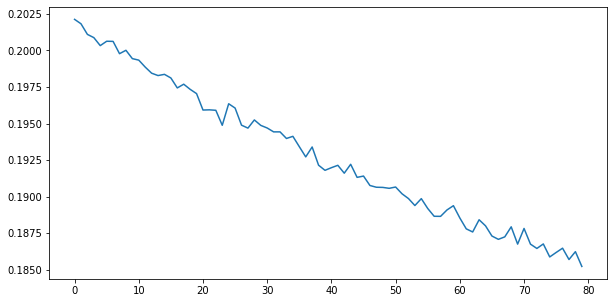

Training accuracy: 0.9237631559371948
Testing accuracy: 0.8982157111167908


In [59]:
stats = model.fit(xsc_train, y_train, epochs=80, validation_data=(xsc_test, y_test), verbose=False)
models.append({'model' : model, 'label': 'Neural Network', 'x_test': xsc_test, 'y_test': y_test})
y_pred = model.predict(xsc_test)
evaluate_model(y_test, y_pred.round())

print('Confusion Matrix :')


train_acc=model.evaluate(xsc_train, y_train, batch_size=1000)[1]
test_acc=model.evaluate(xsc_test, y_test, batch_size=1000)[1]
test_loss, test_accuracy = model.evaluate(xsc_test, y_test)
losses= stats.history['loss']
plt.figure(figsize=(10,5))
plt.plot(range(len(losses)), losses)
plt.show()
print("Training accuracy: %s" % train_acc)
print("Testing accuracy: %s" % test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



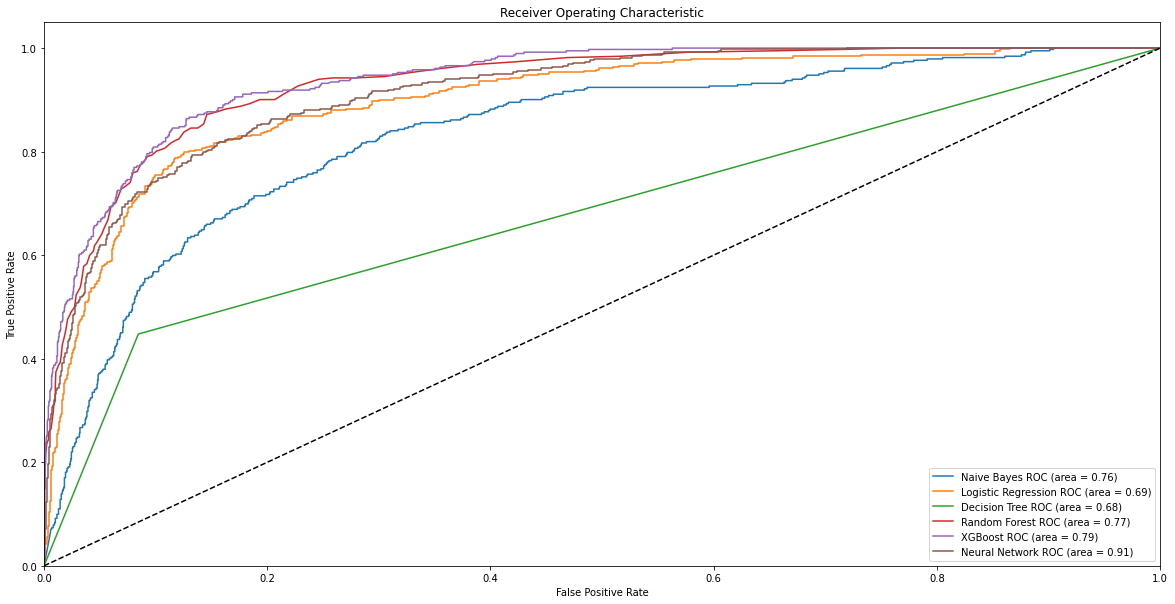

In [60]:
## ROC PLOT for Normalized data

plt.figure(figsize=(20,10))
for m in models:
  model = m['model']
  x_test = m['x_test']
  y_test = m['y_test']
  pred_proba = model.predict_proba(x_test)
  if m['label'] != 'Neural Network':
    pred_proba = pred_proba[:,1]
  # Compute False postive rate, and True positive rate
  fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
  # Calculate Area under the curve to display on the plot
  auc = roc_auc_score(y_test,model.predict(x_test))
  # Now, plot the computed values
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

SMOTE APPLIED

In [61]:
## Imbalanced Data Technique 

## SMOTE - Synthetic Minority Oversampling TEchnique
def smote_data(X_train, y_train):
  smt = SMOTE()
  return smt.fit_sample(X_train, y_train)

In [62]:
#X_train, X_test, y_train, y_test = train_test(temp_data, 0.3)
X_train, X_test, y_train, y_test = train_test(temp_data, 0.2)
X, y = smote_data(X_train, y_train)

print("Shape of X_train after SMOTE:", X.shape)
print("Shape of X_test after SMOTE :", X_test.shape)

Shape of X_train after SMOTE: (16676, 17)
Shape of X_test after SMOTE : (2466, 17)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Testing Accuracy :  0.8029197080291971
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      2084
           1       0.42      0.73      0.53       382

    accuracy                           0.80      2466
   macro avg       0.68      0.77      0.70      2466
weighted avg       0.86      0.80      0.82      2466

[[1703  381]
 [ 105  277]]
Sensitivity/tp_rate =  0.725130890052356
Specificity/tn_rate =  0.8171785028790787
fp rate =  0.1828214971209213
fn rate =  0.27486910994764396
Confusion Matrix :


(0.725130890052356,
 0.8171785028790787,
 0.1828214971209213,
 0.27486910994764396)

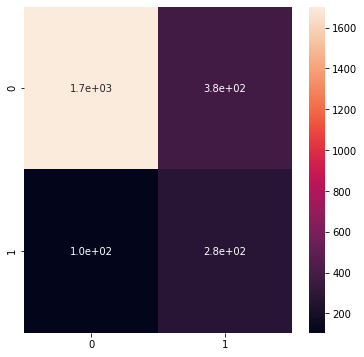

In [76]:
## NAIVE BAYES with SMOTE
models_smote = []
gnb_smote = GaussianNB()

y_pred = gnb_smote.fit(X, y).predict(X_test)

models_smote.append({'model' : gnb_smote, 'label': 'Naive Bayes', 'x_test': X_test, 'y_test': y_test})
#print('Training Accuracy : ', gnb.score(X, y))
evaluate_model(y_test, y_pred)

Testing Accuracy :  0.878345498783455
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2084
           1       0.58      0.74      0.65       382

    accuracy                           0.88      2466
   macro avg       0.77      0.82      0.79      2466
weighted avg       0.89      0.88      0.88      2466

[[1882  202]
 [  98  284]]
Sensitivity/tp_rate =  0.743455497382199
Specificity/tn_rate =  0.9030710172744721
fp rate =  0.09692898272552783
fn rate =  0.25654450261780104
Confusion Matrix :


(0.743455497382199,
 0.9030710172744721,
 0.09692898272552783,
 0.25654450261780104)

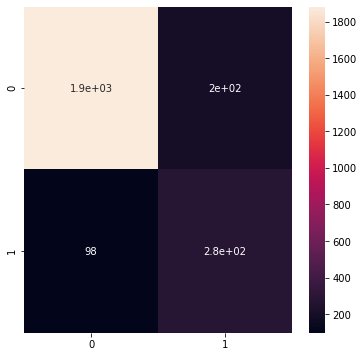

In [77]:
# Logositic Regression With SMOTE

model = LogisticRegression(max_iter=4000)

#x, y = smote_data(x_train, y_train)

model.fit(X,y)

y_pred = model.predict(X_test)
#print('Training Accuracy : ', model.score(X, y))


models_smote.append({'model' : model, 'label': 'Logistic Regression', 'x_test': X_test, 'y_test': y_test})

evaluate_model(y_test, y_pred)

Testing Accuracy :  0.8661800486618005
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2084
           1       0.56      0.63      0.59       382

    accuracy                           0.87      2466
   macro avg       0.75      0.77      0.76      2466
weighted avg       0.87      0.87      0.87      2466

[[1895  189]
 [ 141  241]]
Sensitivity/tp_rate =  0.6308900523560209
Specificity/tn_rate =  0.9093090211132437
fp rate =  0.09069097888675624
fn rate =  0.36910994764397903
Confusion Matrix :


(0.6308900523560209,
 0.9093090211132437,
 0.09069097888675624,
 0.36910994764397903)

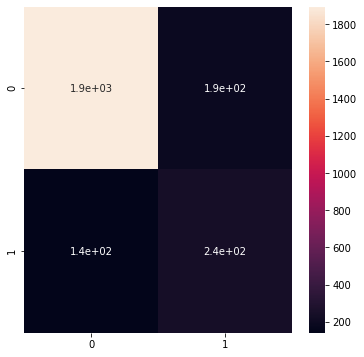

In [78]:
## Decision Tree With SMOTE Data

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X, y)

y_pred = model.predict(X_test)

models_smote.append({'model' : model, 'label': 'Decision Tree', 'x_test': X_test, 'y_test': y_test})


evaluate_model(y_test, y_pred)

Testing Accuracy :  0.8994322789943228
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2084
           1       0.67      0.69      0.68       382

    accuracy                           0.90      2466
   macro avg       0.81      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466

[[1956  128]
 [ 120  262]]
Sensitivity/tp_rate =  0.6858638743455497
Specificity/tn_rate =  0.9385796545105566
fp rate =  0.061420345489443376
fn rate =  0.31413612565445026
Confusion Matrix :


(0.6858638743455497,
 0.9385796545105566,
 0.061420345489443376,
 0.31413612565445026)

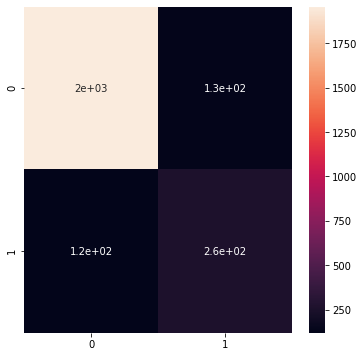

In [79]:

# RandomForest with SMOTE applied data

#X, y = smote_data(X_train, y_train)


model = RandomForestClassifier()

model.fit(X, y)

y_pred = model.predict(X_test)

models_smote.append({'model' : model, 'label': 'Random Forest', 'x_test': X_test, 'y_test': y_test})



evaluate_model(y_test, y_pred)

Testing Accuracy :  0.8933495539334956
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      2084
           1       0.64      0.72      0.68       382

    accuracy                           0.89      2466
   macro avg       0.79      0.82      0.81      2466
weighted avg       0.90      0.89      0.90      2466

[[1927  157]
 [ 106  276]]
Sensitivity/tp_rate =  0.7225130890052356
Specificity/tn_rate =  0.9246641074856046
fp rate =  0.07533589251439539
fn rate =  0.2774869109947644
Confusion Matrix :


(0.7225130890052356,
 0.9246641074856046,
 0.07533589251439539,
 0.2774869109947644)

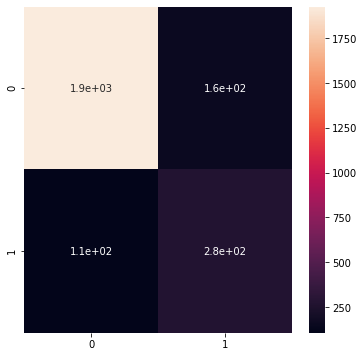

In [80]:
## XGBoost with SMOTE Data

from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = XGBClassifier()

model.fit(X, y)

models_smote.append({'model' : model, 'label': 'XGboost', 'x_test': X_test, 'y_test': y_test})


y_pred = model.predict(X_test.values)
evaluate_model(y_test, y_pred)

In [81]:
##NEURAL NETWORK with smote data

model = k.Sequential([
    k.layers.Dense(60, input_shape=(X_train.shape[1],), activation=tf.nn.relu),
    k.layers.Dense(units=1, activation=tf.nn.sigmoid)
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 60)                1080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 61        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


Testing Accuracy :  0.8905109489051095
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2084
           1       0.65      0.65      0.65       382

    accuracy                           0.89      2466
   macro avg       0.79      0.79      0.79      2466
weighted avg       0.89      0.89      0.89      2466

[[1947  137]
 [ 133  249]]
Sensitivity/tp_rate =  0.6518324607329843
Specificity/tn_rate =  0.9342610364683301
fp rate =  0.06573896353166987
fn rate =  0.3481675392670157
Confusion Matrix :
Confusion Matrix :
78/78 [==============================] - 0s 894us/step - loss: 0.4643 - accuracy: 0.8905


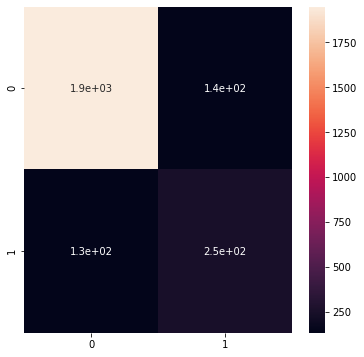

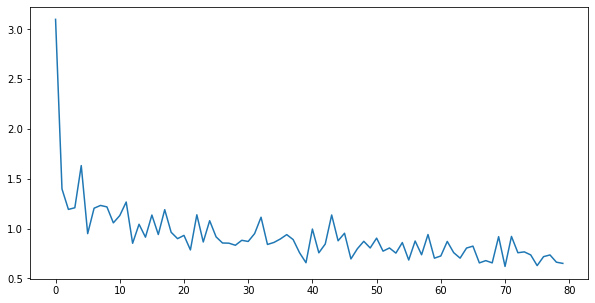

Training accuracy: 0.8096066117286682
Testing accuracy: 0.8905109763145447


In [82]:
stats = model.fit(X, y, epochs=80, validation_data=(X_test, y_test), verbose=False)
models_smote.append({'model' : model, 'label': 'Neural Network', 'x_test': X_test, 'y_test': y_test})

y_pred = model.predict(X_test)
evaluate_model(y_test, y_pred.round())

print('Confusion Matrix :')

train_acc=model.evaluate(X, y, batch_size=1000)[1]
test_acc=model.evaluate(X_test, y_test, batch_size=1000)[1]
test_loss, test_accuracy = model.evaluate(X_test, y_test)
losses= stats.history['loss']
plt.figure(figsize=(10,5))
plt.plot(range(len(losses)), losses)
plt.show()
print("Training accuracy: %s" % train_acc)
print("Testing accuracy: %s" % test_acc)

In [83]:
models_smote

[{'label': 'Naive Bayes',
  'model': GaussianNB(priors=None, var_smoothing=1e-09),
  'x_test':        Administrative  Administrative_Duration  ...  VisitorType  Weekend
  7949                0                      0.0  ...            1        0
  4113                0                      0.0  ...            1        0
  351                 0                      0.0  ...            1        0
  4310                0                      0.0  ...            1        1
  1598                0                      0.0  ...            1        0
  ...               ...                      ...  ...          ...      ...
  2841                0                      0.0  ...            1        0
  11718               0                      0.0  ...            1        0
  11695               5                     29.0  ...            1        0
  6830                0                      0.0  ...            1        0
  424                 4                     74.0  ...            1     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



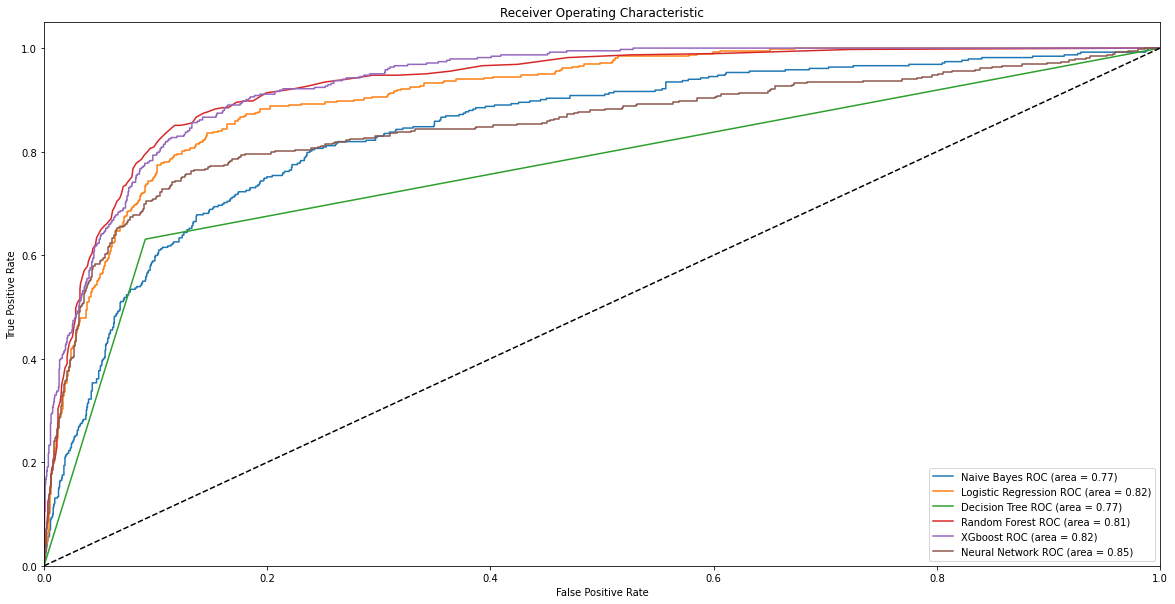

In [86]:
## ROC PLOT for SMOTE data

plt.figure(figsize=(20,10))
for m in models_smote:
  model = m['model']
  x_test = m['x_test']
  y_test = m['y_test']
  pred_proba = model.predict_proba(x_test.values)
  if m['label'] != 'Neural Network':
    pred_proba = pred_proba[:,1]
  # Compute False postive rate, and True positive rate
  fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
  # Calculate Area under the curve to display on the plot
  auc = roc_auc_score(y_test,model.predict(x_test.values))
  # Now, plot the computed values
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Feature Engineering: PCA


In [156]:
x_train, x_test, y_train, y_test = train_test(temp_data, 0.2)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train: (9864, 17)
Shape of x_test : (2466, 17)
Shape of y_train : (9864,)
Shape of y_test : (2466,)


In [88]:
##Normalizing data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

xsc_train = sc.fit_transform(x_train)
xsc_test = sc.fit_transform(x_test)

In [89]:

# feature selection by Principal Component Analysis

from sklearn.decomposition import PCA

pca = PCA(n_components = None)

xpca_train = pca.fit_transform(xsc_train)
xpca_test = pca.transform(xsc_test)

Testing Accuracy :  0.8410381184103812
Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      2084
           1       0.48      0.41      0.44       382

    accuracy                           0.84      2466
   macro avg       0.69      0.66      0.67      2466
weighted avg       0.83      0.84      0.84      2466

[[1919  165]
 [ 227  155]]
Sensitivity/tp_rate =  0.40575916230366493
Specificity/tn_rate =  0.9208253358925144
fp rate =  0.07917466410748561
fn rate =  0.5942408376963351
Confusion Matrix :


(0.40575916230366493,
 0.9208253358925144,
 0.07917466410748561,
 0.5942408376963351)

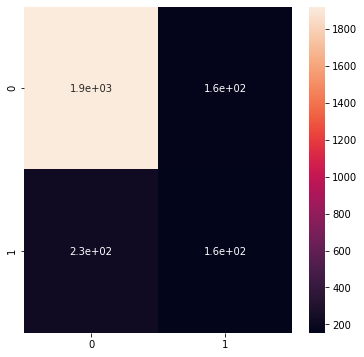

In [90]:
## NAIVE BAYES with PCA
models_pca = []
gnb = GaussianNB()

#x, y = smote_data(X_train, y_train)

y_pred = gnb.fit(xpca_train, y_train).predict(xpca_test)

models_pca.append({'model' : gnb, 'label': 'Naive Bayes', 'x_test': xpca_test, 'y_test': y_test})

#print('Training Accuracy : ', gnb.score(xpca_train, y_train))

evaluate_model(y_test, y_pred)

Testing Accuracy :  0.8856447688564477
Classification Report :
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2084
           1       0.75      0.40      0.52       382

    accuracy                           0.89      2466
   macro avg       0.82      0.69      0.73      2466
weighted avg       0.87      0.89      0.87      2466

[[2033   51]
 [ 231  151]]
Sensitivity/tp_rate =  0.39528795811518325
Specificity/tn_rate =  0.97552783109405
fp rate =  0.024472168905950095
fn rate =  0.6047120418848168
Confusion Matrix :


(0.39528795811518325,
 0.97552783109405,
 0.024472168905950095,
 0.6047120418848168)

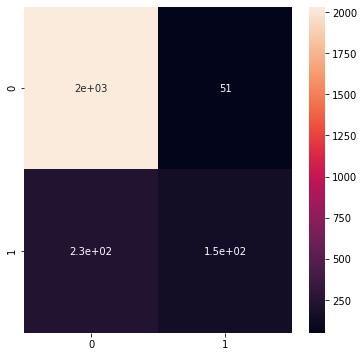

In [91]:
## Logistic Regression with PCA
model = LogisticRegression(max_iter=4000)

#x, y = smote_data(x_train, y_train)
model.fit(xpca_train, y_train)

y_pred = model.predict(xpca_test)


models_pca.append({'model' : model, 'label': 'Logistic Regression', 'x_test': xpca_test, 'y_test': y_test})

evaluate_model(y_test, y_pred)

In [102]:
models_pca


[{'label': 'Naive Bayes',
  'model': GaussianNB(priors=None, var_smoothing=1e-09),
  'x_test': array([[-1.11584598, -0.088717  , -0.23364002, ..., -0.03251994,
          -0.11641914,  0.05426247],
         [-0.9566786 , -0.01192768, -1.62436155, ..., -0.00695052,
          -0.28566931, -0.04141783],
         [-1.26077349, -0.32721546,  0.75795219, ..., -0.04361968,
          -0.12882133, -0.10623109],
         ...,
         [ 1.55763811, -0.14481626,  0.30231968, ...,  0.54647537,
           0.11422232, -0.08857469],
         [-3.43954095,  3.77787352,  0.64129227, ...,  0.07908225,
          -0.10046809, -0.25740373],
         [ 4.31229145,  1.98128209, -1.04833378, ...,  2.04323999,
          -0.70464429, -0.0328723 ]]),
  'y_test': 7949     0
  4113     0
  351      0
  4310     0
  1598     0
          ..
  2841     0
  11718    0
  11695    0
  6830     0
  424      1
  Name: Revenue, Length: 2466, dtype: int64},
 {'label': 'Logistic Regression',
  'model': LogisticRegression(C=1.

Testing Accuracy :  0.8260340632603407
Classification Report :
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2084
           1       0.44      0.49      0.47       382

    accuracy                           0.83      2466
   macro avg       0.67      0.69      0.68      2466
weighted avg       0.83      0.83      0.83      2466

[[1850  234]
 [ 195  187]]
Sensitivity/tp_rate =  0.4895287958115183
Specificity/tn_rate =  0.8877159309021113
fp rate =  0.11228406909788867
fn rate =  0.5104712041884817
Confusion Matrix :


(0.4895287958115183,
 0.8877159309021113,
 0.11228406909788867,
 0.5104712041884817)

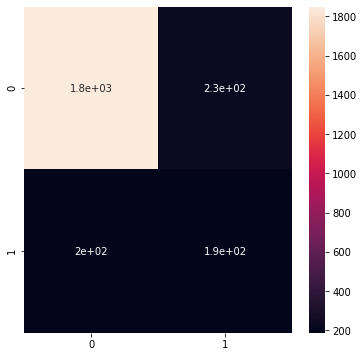

In [103]:
## Decision Tree with PCA
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(xpca_train, y_train)

y_pred = model.predict(xpca_test)

models_pca.append({'model' : model, 'label': 'Decison Tree', 'x_test': xpca_test, 'y_test': y_test})

evaluate_model(y_test, y_pred)

Testing Accuracy :  0.8929440389294404
Classification Report :
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2084
           1       0.78      0.43      0.56       382

    accuracy                           0.89      2466
   macro avg       0.84      0.71      0.75      2466
weighted avg       0.88      0.89      0.88      2466

[[2036   48]
 [ 216  166]]
Sensitivity/tp_rate =  0.43455497382198954
Specificity/tn_rate =  0.9769673704414588
fp rate =  0.023032629558541268
fn rate =  0.5654450261780105
Confusion Matrix :


(0.43455497382198954,
 0.9769673704414588,
 0.023032629558541268,
 0.5654450261780105)

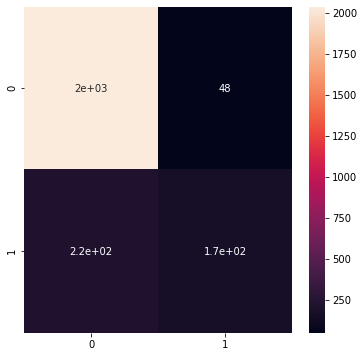

In [104]:
## Random Forests with PCA
model = RandomForestClassifier()
model.fit(xpca_train, y_train)

y_pred = model.predict(xpca_test)

models_pca.append({'model' : model, 'label': 'Random Forest', 'x_test': xpca_test, 'y_test': y_test})

evaluate_model(y_test, y_pred)

Testing Accuracy :  0.8901054339010543
Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2084
           1       0.74      0.45      0.56       382

    accuracy                           0.89      2466
   macro avg       0.82      0.71      0.75      2466
weighted avg       0.88      0.89      0.88      2466

[[2025   59]
 [ 212  170]]
Sensitivity/tp_rate =  0.44502617801047123
Specificity/tn_rate =  0.9716890595009597
fp rate =  0.02831094049904031
fn rate =  0.5549738219895288
Confusion Matrix :


(0.44502617801047123,
 0.9716890595009597,
 0.02831094049904031,
 0.5549738219895288)

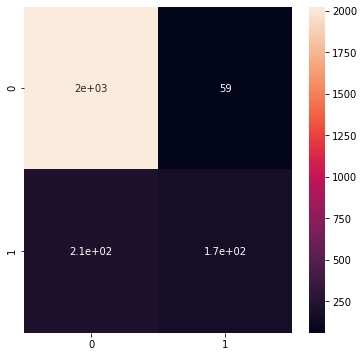

In [105]:
## XGBoost with PCA Data

from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = XGBClassifier()

model.fit(xpca_train, y_train)

models_pca.append({'model' : model, 'label': 'XGBoost', 'x_test': xpca_test, 'y_test': y_test})

y_pred = model.predict(xpca_test)
evaluate_model(y_test, y_pred)

In [107]:
##NEURAL NETWORK with pca data

model = k.Sequential([
    k.layers.Dense(60, input_shape=(x_train.shape[1],), activation=tf.nn.relu),
    k.layers.Dense(units=1, activation=tf.nn.sigmoid)
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 60)                1080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 61        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


Testing Accuracy :  0.8998377939983779
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2084
           1       0.71      0.61      0.65       382

    accuracy                           0.90      2466
   macro avg       0.82      0.78      0.80      2466
weighted avg       0.90      0.90      0.90      2466

[[1987   97]
 [ 150  232]]
Sensitivity/tp_rate =  0.6073298429319371
Specificity/tn_rate =  0.9534548944337812
fp rate =  0.04654510556621881
fn rate =  0.39267015706806285
Confusion Matrix :
Confusion Matrix :
78/78 [==============================] - 0s 881us/step - loss: 0.2407 - accuracy: 0.8998


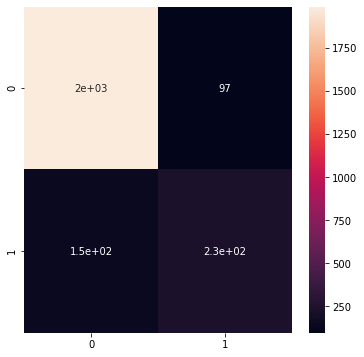

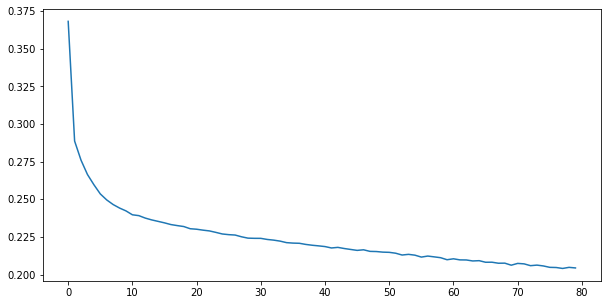

Training accuracy: 0.9146391153335571
Testing accuracy: 0.8998377919197083


In [108]:
stats = model.fit(xpca_train, y_train, epochs=80, validation_data=(xpca_test, y_test), verbose=False)
models_pca.append({'model' : model, 'label': 'Neural Network', 'x_test': xpca_test, 'y_test': y_test})
y_pred = model.predict(xpca_test)
evaluate_model(y_test, y_pred.round())

print('Confusion Matrix :')

train_acc=model.evaluate(xpca_train, y_train, batch_size=1000)[1]
test_acc=model.evaluate(xpca_test, y_test, batch_size=1000)[1]
test_loss, test_accuracy = model.evaluate(xpca_test, y_test)
losses= stats.history['loss']
plt.figure(figsize=(10,5))
plt.plot(range(len(losses)), losses)
plt.show()
print("Training accuracy: %s" % train_acc)
print("Testing accuracy: %s" % test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



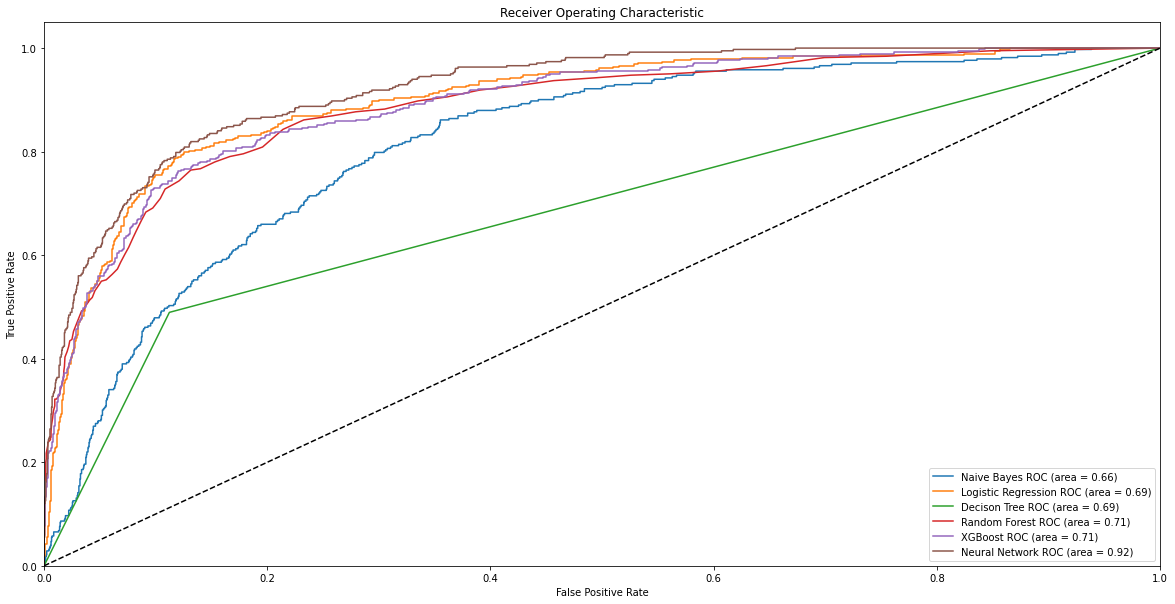

In [109]:
## ROC curve of Models with PCA

plt.figure(figsize=(20,10))
for m in models_pca:
  model = m['model']
  x_test = m['x_test']
  y_test = m['y_test']
  pred_proba = model.predict_proba(x_test)
  if m['label'] != 'Neural Network':
    pred_proba = pred_proba[:,1]
  # Compute False postive rate, and True positive rate
  fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
  # Calculate Area under the curve to display on the plot
  auc = roc_auc_score(y_test,model.predict(x_test))
  # Now, plot the computed values
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Feature Engineering: Recursive Feature Elimination

In [157]:
x_train, x_test, y_train, y_test = train_test(temp_data, 0.2)

Testing Accuracy :  0.8552311435523114
Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2084
           1       0.53      0.52      0.53       382

    accuracy                           0.86      2466
   macro avg       0.72      0.72      0.72      2466
weighted avg       0.85      0.86      0.85      2466

[[1911  173]
 [ 184  198]]
Sensitivity/tp_rate =  0.518324607329843
Specificity/tn_rate =  0.9169865642994242
fp rate =  0.08301343570057582
fn rate =  0.4816753926701571
Confusion Matrix :


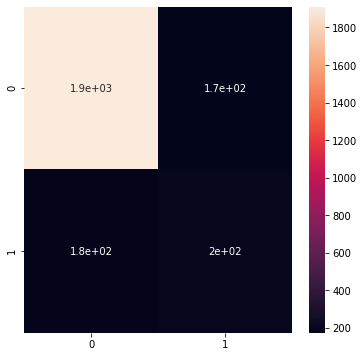

In [141]:
## NaiveBayes with RFE

models_rfe = []

selected_features_nb= ['Administrative', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'Region', 'TrafficType']
x_train_rfe = x_train[selected_features_nb]
x_test_rfe = x_test[selected_features_nb]

#x_train_rfe, y_train_rfe = smotify(x_train[selected_features], y_train)

model_rfe = GaussianNB()

model_rfe.fit(x_train_rfe, y_train)

y_pred = model_rfe.predict(x_test_rfe)
evaluate_model(y_test, y_pred)
models_rfe.append({'model' : model_rfe, 'label': 'Naive Bayes', 'x_test': x_test_rfe, 'y_test': y_test})



Optimal number of features: 10
Selected features: ['Administrative', 'Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'Region', 'TrafficType']


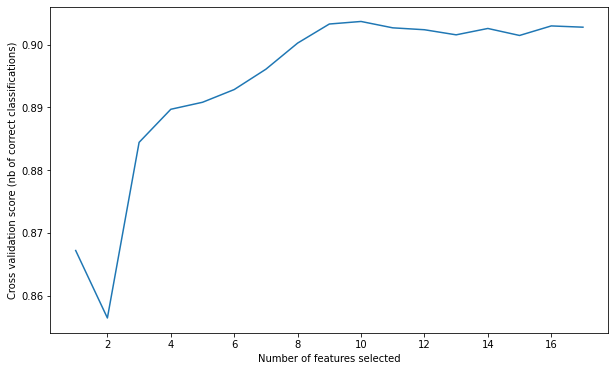

In [142]:
# Random Forest Classifier with RFE 

from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=RandomForestClassifier(), step=1, cv=10, scoring='accuracy')
rfecv.fit(x_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x_train.columns[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Testing Accuracy :  0.9083536090835361
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2084
           1       0.77      0.59      0.67       382

    accuracy                           0.91      2466
   macro avg       0.85      0.78      0.81      2466
weighted avg       0.90      0.91      0.90      2466

[[2015   69]
 [ 157  225]]
Sensitivity/tp_rate =  0.5890052356020943
Specificity/tn_rate =  0.966890595009597
fp rate =  0.033109404990403074
fn rate =  0.4109947643979058
Confusion Matrix :


(0.5890052356020943,
 0.966890595009597,
 0.033109404990403074,
 0.4109947643979058)

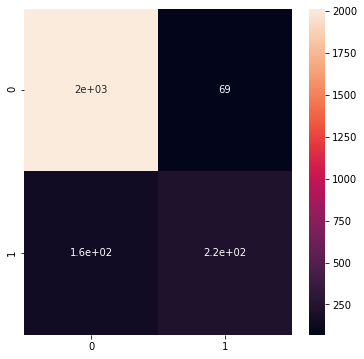

In [143]:
selected_features = list(x_train.columns[rfecv.support_])
x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]

#x_train_rfe, y_train_rfe = smotify(x_train[selected_features], y_train)

model_rfe = RandomForestClassifier()

model_rfe.fit(x_train_rfe, y_train)

y_pred = model_rfe.predict(x_test_rfe)

models_rfe.append({'model' : model_rfe, 'label': 'Random Forest', 'x_test': x_test_rfe, 'y_test': y_test})

#models.append({'model' : model_rfe, 'label': 'Random Forest Search', 'x_test': x_test_rfe, 'y_test': y_test})

evaluate_model(y_test, y_pred)


Optimal number of features: 9
Selected features: ['Informational', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'VisitorType', 'Weekend']


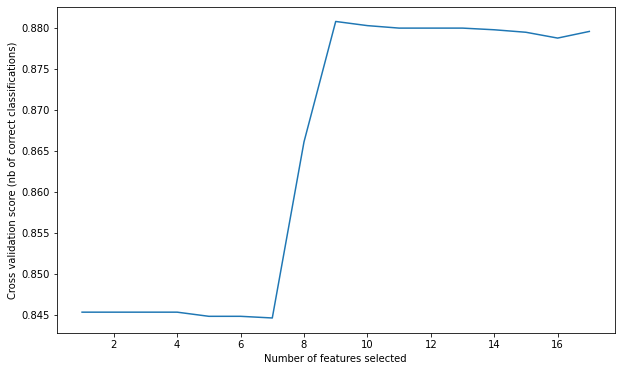

In [144]:
##Logistic Regression RFE
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications

rfecv = RFECV(estimator=LogisticRegression(max_iter=4000), step=1, cv=10, scoring='accuracy')
rfecv.fit(x_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x_train.columns[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Testing Accuracy :  0.8868613138686131
Classification Report :
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2084
           1       0.76      0.39      0.52       382

    accuracy                           0.89      2466
   macro avg       0.83      0.68      0.73      2466
weighted avg       0.88      0.89      0.87      2466

[[2038   46]
 [ 233  149]]
Sensitivity/tp_rate =  0.3900523560209424
Specificity/tn_rate =  0.9779270633397313
fp rate =  0.022072936660268713
fn rate =  0.6099476439790575
Confusion Matrix :


(0.3900523560209424,
 0.9779270633397313,
 0.022072936660268713,
 0.6099476439790575)

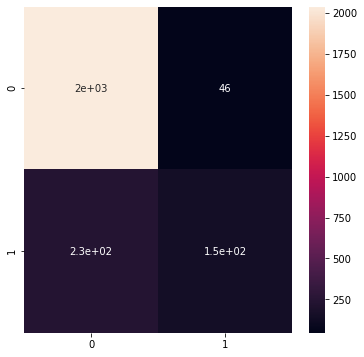

In [145]:
selected_features = list(x_train.columns[rfecv.support_])
x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]

model_rfe = LogisticRegression(max_iter=4000)

model_rfe.fit(x_train_rfe, y_train)

y_pred = model_rfe.predict(x_test_rfe)

models_rfe.append({'model' : model_rfe, 'label': 'Logistic Regression', 'x_test': x_test_rfe, 'y_test': y_test})

#models.append({'model' : model_rfe, 'label': 'Logistic Regression', 'x_test': x_test_rfe, 'y_test': y_test})

evaluate_model(y_test, y_pred)


Optimal number of features: 1
Selected features: ['PageValues']


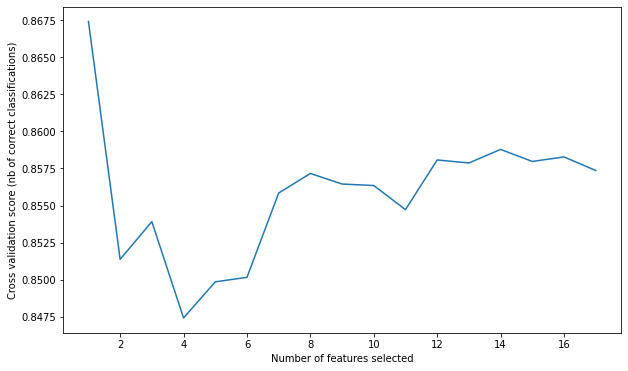

In [146]:
## Decision Tree w/ RFE
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications

rfecv = RFECV(estimator=DecisionTreeClassifier(), step=1, cv=10, scoring='accuracy')
rfecv.fit(x_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x_train.columns[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Testing Accuracy :  0.8734793187347932
Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2084
           1       0.62      0.46      0.53       382

    accuracy                           0.87      2466
   macro avg       0.77      0.70      0.73      2466
weighted avg       0.86      0.87      0.87      2466

[[1979  105]
 [ 207  175]]
Sensitivity/tp_rate =  0.4581151832460733
Specificity/tn_rate =  0.949616122840691
fp rate =  0.05038387715930902
fn rate =  0.5418848167539267
Confusion Matrix :


(0.4581151832460733,
 0.949616122840691,
 0.05038387715930902,
 0.5418848167539267)

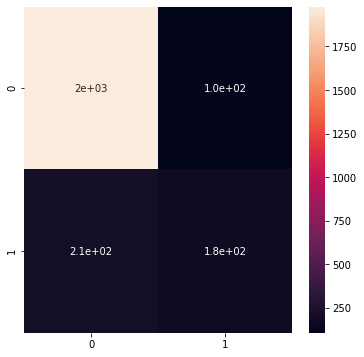

In [147]:
selected_features = list(x_train.columns[rfecv.support_])
x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]
#x_train_rfe, y_train_rfe = smotify(x_train[selected_features], y_train)

model_rfe = DecisionTreeClassifier()

model_rfe.fit(x_train_rfe, y_train)

y_pred = model_rfe.predict(x_test_rfe)

models_rfe.append({'model' : model_rfe, 'label': 'Decison Tree', 'x_test': x_test_rfe, 'y_test': y_test})

#models.append({'model' : model_rfe, 'label': 'Logistic Regression', 'x_test': x_test_rfe, 'y_test': y_test})

evaluate_model(y_test, y_pred)

In [160]:
## Neural Network W/ RFE
selected_features_nn = ['Administrative', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'Region', 'TrafficType']
x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]

In [161]:
model_rfe = k.Sequential([
    k.layers.Dense(60, input_shape=(x_train_rfe.shape[1],), activation=tf.nn.relu),
    k.layers.Dense(units=1, activation=tf.nn.sigmoid)
])

model_rfe.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model_rfe.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 60)                600       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 61        
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________


In [170]:
models_rfe.pop(5)

{'label': 'Neural Network',
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f8e0a81ee50>,
 'x_test':        Administrative  Informational  ...  Month  VisitorType
 7949                0              0  ...      7            1
 4113                0              0  ...      5            1
 351                 0              0  ...      3            1
 4310                0              0  ...      5            1
 1598                0              0  ...      3            1
 ...               ...            ...  ...    ...          ...
 2841                0              0  ...      5            1
 11718               0              0  ...     11            1
 11695               5              0  ...     12            1
 6830                0              0  ...      7            1
 424                 4              2  ...      3            1
 
 [2466 rows x 9 columns],
 'y_test': 7949     0
 4113     0
 351      0
 4310     0
 1598     0
         ..
 2841     0


Testing Accuracy :  0.875506893755069
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2084
           1       0.58      0.75      0.65       382

    accuracy                           0.88      2466
   macro avg       0.76      0.82      0.79      2466
weighted avg       0.89      0.88      0.88      2466

[[1872  212]
 [  95  287]]
Sensitivity/tp_rate =  0.7513089005235603
Specificity/tn_rate =  0.8982725527831094
fp rate =  0.1017274472168906
fn rate =  0.2486910994764398
Confusion Matrix :
Confusion Matrix :
78/78 [==============================] - 0s 874us/step - loss: 0.2860 - accuracy: 0.8755


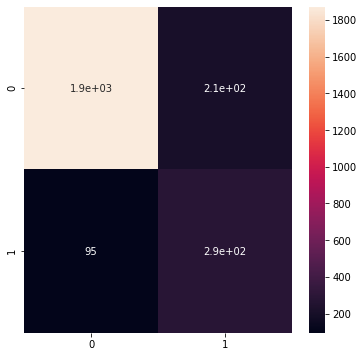

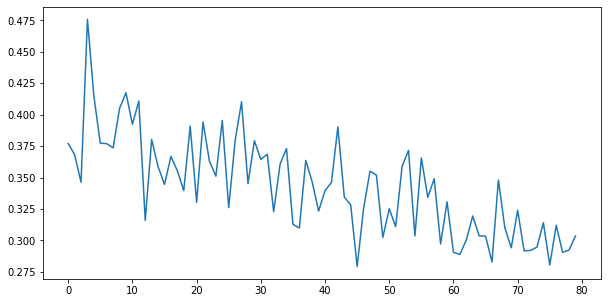

Training accuracy: 0.8735806941986084
Testing accuracy: 0.8755068778991699


In [171]:

stats = model_rfe.fit(x_train_rfe, y_train, epochs=80, validation_data=(x_test_rfe, y_test), verbose=False)
models_rfe.append({'model' : model_rfe, 'label': 'Neural Network', 'x_test': x_test_rfe, 'y_test': y_test})

y_pred = model_rfe.predict(x_test_rfe)
evaluate_model(y_test, y_pred.round())

print('Confusion Matrix :')

train_acc=model_rfe.evaluate(x_train_rfe, y_train, batch_size=1000)[1]
test_acc=model_rfe.evaluate(x_test_rfe, y_test, batch_size=1000)[1]
test_loss, test_accuracy = model_rfe.evaluate(x_test_rfe, y_test)
losses= stats.history['loss']
plt.figure(figsize=(10,5))
plt.plot(range(len(losses)), losses)
plt.show()
print("Training accuracy: %s" % train_acc)
print("Testing accuracy: %s" % test_acc)

Optimal number of features: 9
Selected features: ['Administrative', 'Informational', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'VisitorType']


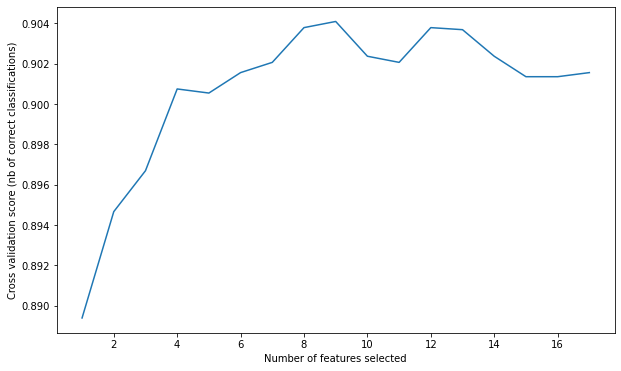

In [151]:
## XGBoost with RFE
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications

rfecv = RFECV(estimator=XGBClassifier(), step=1, cv=10, scoring='accuracy')
rfecv.fit(x_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x_train.columns[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Testing Accuracy :  0.9111922141119222
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2084
           1       0.75      0.64      0.69       382

    accuracy                           0.91      2466
   macro avg       0.84      0.80      0.82      2466
weighted avg       0.91      0.91      0.91      2466

[[2002   82]
 [ 137  245]]
Sensitivity/tp_rate =  0.6413612565445026
Specificity/tn_rate =  0.9606525911708254
fp rate =  0.03934740882917467
fn rate =  0.3586387434554974
Confusion Matrix :


(0.6413612565445026,
 0.9606525911708254,
 0.03934740882917467,
 0.3586387434554974)

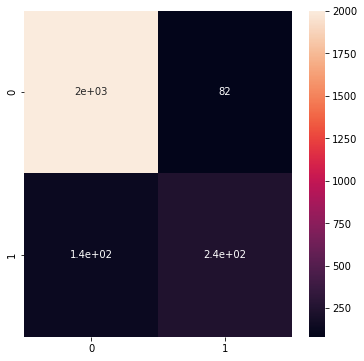

In [152]:
selected_features = list(x_train.columns[rfecv.support_])
x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]
#x_train_rfe, y_train_rfe = smotify(x_train[selected_features], y_train)

model_rfe = XGBClassifier()

model_rfe.fit(x_train_rfe, y_train)

y_pred = model_rfe.predict(x_test_rfe)

models_rfe.append({'model' : model_rfe, 'label': 'XGBoost', 'x_test': x_test_rfe, 'y_test': y_test})


evaluate_model(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



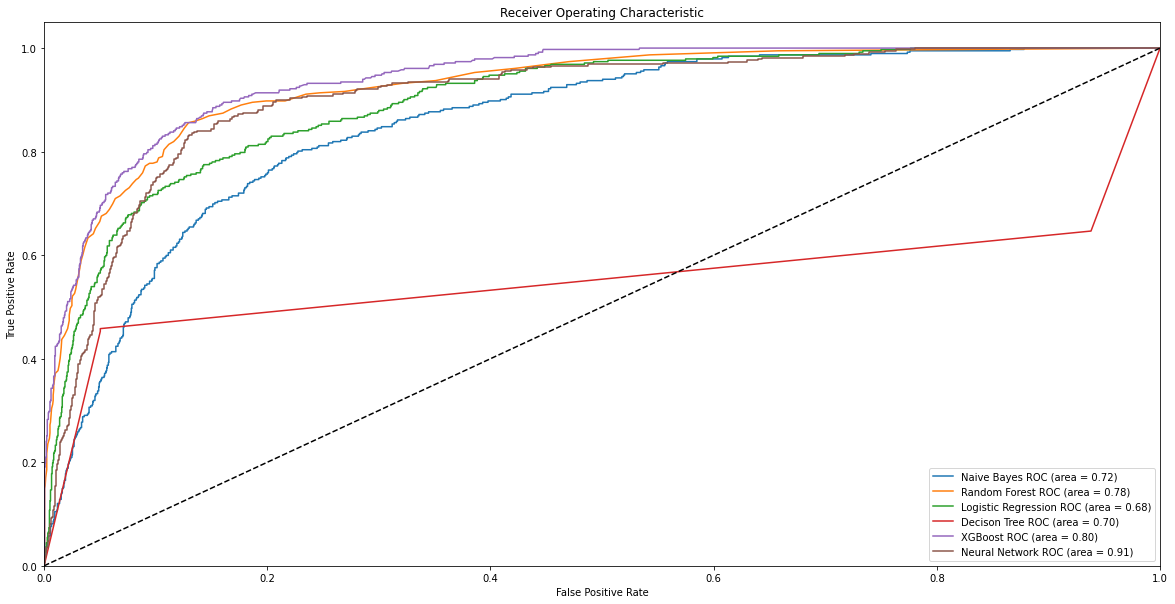

In [172]:
# plotting ROC curves for RFE


plt.figure(figsize=(20,10))
for m in models_rfe:
  model = m['model']
  x_test = m['x_test']
  y_test = m['y_test']
  pred_proba = model.predict_proba(x_test)
  if m['label'] != 'Neural Network':
    pred_proba = pred_proba[:,1]
  # Compute False postive rate, and True positive rate
  fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
  # Calculate Area under the curve to display on the plot
  auc = roc_auc_score(y_test,model.predict(x_test))
  # Now, plot the computed values
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [167]:
models_rfe.pop(5)

{'label': 'Neural Network',
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f8e0a81ee50>,
 'x_test':        Administrative  Informational  ...  Month  VisitorType
 7949                0              0  ...      7            1
 4113                0              0  ...      5            1
 351                 0              0  ...      3            1
 4310                0              0  ...      5            1
 1598                0              0  ...      3            1
 ...               ...            ...  ...    ...          ...
 2841                0              0  ...      5            1
 11718               0              0  ...     11            1
 11695               5              0  ...     12            1
 6830                0              0  ...      7            1
 424                 4              2  ...      3            1
 
 [2466 rows x 9 columns],
 'y_test': 7949     0
 4113     0
 351      0
 4310     0
 1598     0
         ..
 2841     0


RFE + SMOTE

In [173]:
x_train, x_test, y_train, y_test = train_test(temp_data, 0.2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Testing Accuracy :  0.8418491484184915
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      2084
           1       0.49      0.67      0.57       382

    accuracy                           0.84      2466
   macro avg       0.71      0.77      0.74      2466
weighted avg       0.87      0.84      0.85      2466

[[1819  265]
 [ 125  257]]
Sensitivity/tp_rate =  0.6727748691099477
Specificity/tn_rate =  0.8728406909788867
fp rate =  0.12715930902111325
fn rate =  0.32722513089005234
Confusion Matrix :


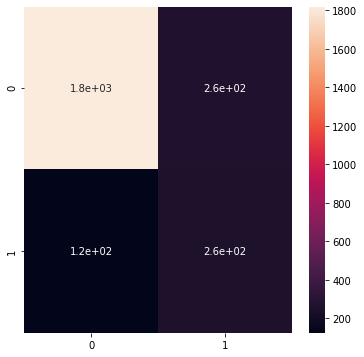

In [174]:
## Naive Bayes with RFE AND SMOTE

models_rfe_smote = []
selected_features_nn = ['Administrative', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'Region', 'TrafficType']
#x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]

x_train_rfe, y_train_rfe = smote_data(x_train[selected_features], y_train)

model_rfe = GaussianNB()

model_rfe.fit(x_train_rfe, y_train_rfe)

y_pred = model_rfe.predict(x_test_rfe)
evaluate_model(y_test, y_pred)
models_rfe_smote.append({'model' : model_rfe, 'label': 'Naive Bayes', 'x_test': x_test_rfe, 'y_test': y_test})


Optimal number of features: 9
Selected features: ['Informational', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'VisitorType', 'Weekend']


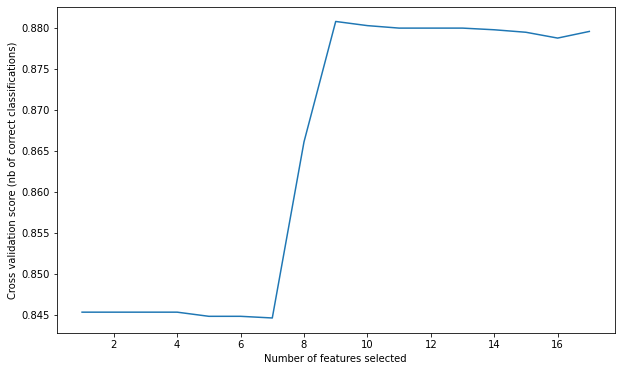

In [175]:
##Logistic Regression RFE w/ smote

from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications

rfecv = RFECV(estimator=LogisticRegression(max_iter=4000), step=1, cv=10, scoring='accuracy')
rfecv.fit(x_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x_train.columns[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Testing Accuracy :  0.8803730738037308
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2084
           1       0.59      0.73      0.65       382

    accuracy                           0.88      2466
   macro avg       0.77      0.82      0.79      2466
weighted avg       0.89      0.88      0.89      2466

[[1891  193]
 [ 102  280]]
Sensitivity/tp_rate =  0.7329842931937173
Specificity/tn_rate =  0.9073896353166987
fp rate =  0.09261036468330135
fn rate =  0.2670157068062827
Confusion Matrix :


(0.7329842931937173,
 0.9073896353166987,
 0.09261036468330135,
 0.2670157068062827)

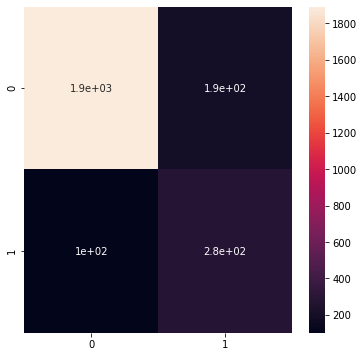

In [176]:
selected_features = list(x_train.columns[rfecv.support_])
#x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]
x_train_rfe, y_train_rfe = smote_data(x_train[selected_features], y_train)

model_rfe = LogisticRegression(max_iter=4000)

model_rfe.fit(x_train_rfe, y_train_rfe)

y_pred = model_rfe.predict(x_test_rfe)

models_rfe_smote.append({'model' : model_rfe, 'label': 'Logistic Regression', 'x_test': x_test_rfe, 'y_test': y_test})

evaluate_model(y_test, y_pred)


Optimal number of features: 14
Selected features: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']


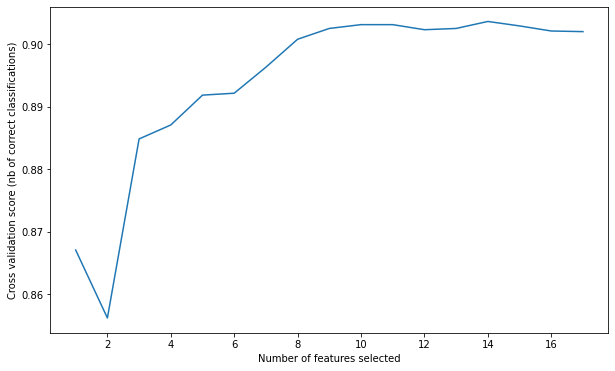

In [177]:
# Random Forest Classiffier with RFE and SMOTE

from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=RandomForestClassifier(), step=1, cv=10, scoring='accuracy')
rfecv.fit(x_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x_train.columns[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Testing Accuracy :  0.8961881589618816
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2084
           1       0.66      0.69      0.67       382

    accuracy                           0.90      2466
   macro avg       0.80      0.81      0.81      2466
weighted avg       0.90      0.90      0.90      2466

[[1948  136]
 [ 120  262]]
Sensitivity/tp_rate =  0.6858638743455497
Specificity/tn_rate =  0.9347408829174664
fp rate =  0.06525911708253358
fn rate =  0.31413612565445026
Confusion Matrix :


(0.6858638743455497,
 0.9347408829174664,
 0.06525911708253358,
 0.31413612565445026)

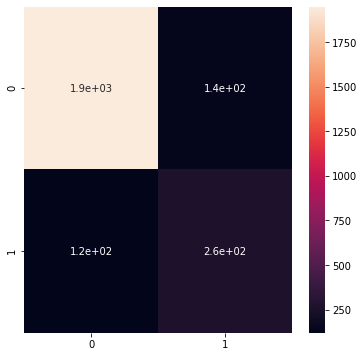

In [178]:
selected_features = list(x_train.columns[rfecv.support_])
#x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]

x_train_rfe, y_train_rfe = smote_data(x_train[selected_features], y_train)

model_rfe = RandomForestClassifier()

model_rfe.fit(x_train_rfe, y_train_rfe)

y_pred = model_rfe.predict(x_test_rfe)

models_rfe_smote.append({'model' : model_rfe, 'label': 'Random Forest', 'x_test': x_test_rfe, 'y_test': y_test})

evaluate_model(y_test, y_pred)

Optimal number of features: 1
Selected features: ['PageValues']


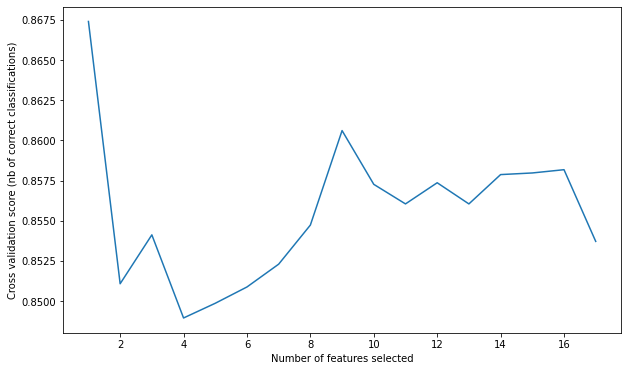

In [179]:
## Decision Tree w/ RFE and SMOTE
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications

rfecv = RFECV(estimator=DecisionTreeClassifier(), step=1, cv=10, scoring='accuracy')
rfecv.fit(x_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x_train.columns[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Testing Accuracy :  0.8779399837793999
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2084
           1       0.60      0.62      0.61       382

    accuracy                           0.88      2466
   macro avg       0.77      0.77      0.77      2466
weighted avg       0.88      0.88      0.88      2466

[[1930  154]
 [ 147  235]]
Sensitivity/tp_rate =  0.6151832460732984
Specificity/tn_rate =  0.9261036468330134
fp rate =  0.07389635316698656
fn rate =  0.38481675392670156
Confusion Matrix :


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



(0.6151832460732984,
 0.9261036468330134,
 0.07389635316698656,
 0.38481675392670156)

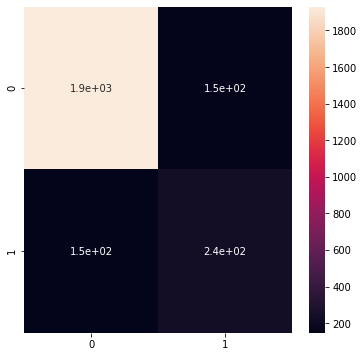

In [180]:
selected_features = list(x_train.columns[rfecv.support_])
#x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]
x_train_rfe, y_train_rfe = smote_data(x_train[selected_features], y_train)

model_rfe = DecisionTreeClassifier()

model_rfe.fit(x_train_rfe, y_train_rfe)

y_pred = model_rfe.predict(x_test_rfe)

models_rfe_smote.append({'model' : model_rfe, 'label': 'Decision Tree', 'x_test': x_test_rfe, 'y_test': y_test})


evaluate_model(y_test, y_pred)

Optimal number of features: 9
Selected features: ['Administrative', 'Informational', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'VisitorType']


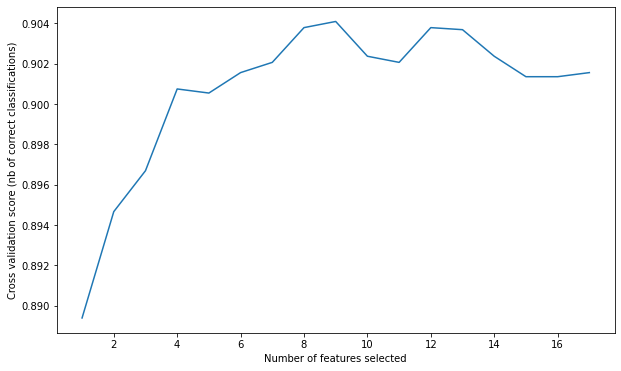

In [181]:
## XGBoost with RFE with SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications

rfecv = RFECV(estimator=XGBClassifier(), step=1, cv=10, scoring='accuracy')
rfecv.fit(x_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x_train.columns[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Testing Accuracy :  0.8937550689375506
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      2084
           1       0.63      0.74      0.68       382

    accuracy                           0.89      2466
   macro avg       0.79      0.83      0.81      2466
weighted avg       0.90      0.89      0.90      2466

[[1921  163]
 [  99  283]]
Sensitivity/tp_rate =  0.7408376963350786
Specificity/tn_rate =  0.9217850287907869
fp rate =  0.07821497120921306
fn rate =  0.2591623036649215
Confusion Matrix :


(0.7408376963350786,
 0.9217850287907869,
 0.07821497120921306,
 0.2591623036649215)

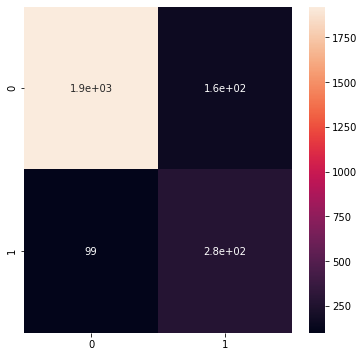

In [182]:
selected_features = list(x_train.columns[rfecv.support_])
#x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]

x_train_rfe, y_train_rfe = smote_data(x_train[selected_features], y_train)

model_rfe = XGBClassifier()

model_rfe.fit(x_train_rfe, y_train_rfe)

y_pred = model_rfe.predict(x_test_rfe.values)

models_rfe_smote.append({'model' : model_rfe, 'label': 'XGBoost', 'x_test': x_test_rfe, 'y_test': y_test})

evaluate_model(y_test, y_pred)

In [183]:
## Neural Network W/ RFE and SMOTE
selected_features_nn = ['Administrative', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'Region', 'TrafficType']
#x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]

x_train_rfe, y_train_rfe = smote_data(x_train[selected_features], y_train)


model = k.Sequential([
    k.layers.Dense(60, input_shape=(x_train_rfe.shape[1],), activation=tf.nn.relu),
    k.layers.Dense(units=1, activation=tf.nn.sigmoid)
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 60)                600       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 61        
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Testing Accuracy :  0.8953771289537713
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2084
           1       0.66      0.66      0.66       382

    accuracy                           0.90      2466
   macro avg       0.80      0.80      0.80      2466
weighted avg       0.90      0.90      0.90      2466

[[1956  128]
 [ 130  252]]
Sensitivity/tp_rate =  0.6596858638743456
Specificity/tn_rate =  0.9385796545105566
fp rate =  0.061420345489443376
fn rate =  0.3403141361256545
Confusion Matrix :
Confusion Matrix :
78/78 [==============================] - 0s 895us/step - loss: 0.2937 - accuracy: 0.8954


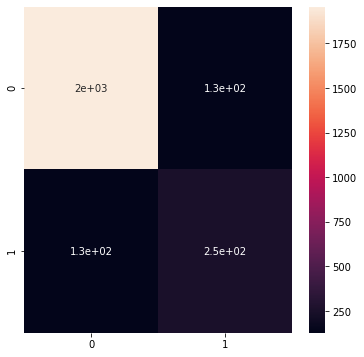

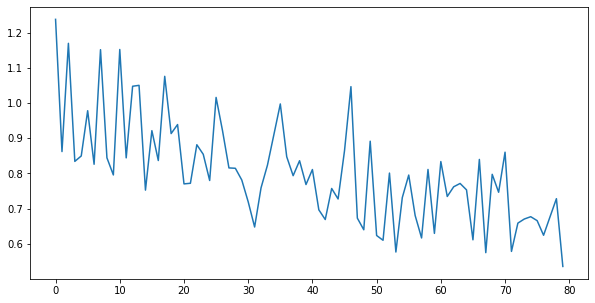

Training accuracy: 0.8139841556549072
Testing accuracy: 0.8953770995140076


In [184]:
stats = model.fit(x_train_rfe, y_train_rfe, epochs=80, validation_data=(x_test_rfe, y_test), verbose=False)
models_rfe_smote.append({'model' : model, 'label': 'Neural Network', 'x_test': x_test_rfe, 'y_test': y_test})

y_pred = model.predict(x_test_rfe)
evaluate_model(y_test, y_pred.round())

print('Confusion Matrix :')

train_acc=model.evaluate(x_train_rfe, y_train_rfe, batch_size=1000)[1]
test_acc=model.evaluate(x_test_rfe, y_test, batch_size=1000)[1]
test_loss, test_accuracy = model.evaluate(x_test_rfe, y_test)
losses= stats.history['loss']
plt.figure(figsize=(10,5))
plt.plot(range(len(losses)), losses)
plt.show()
print("Training accuracy: %s" % train_acc)
print("Testing accuracy: %s" % test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



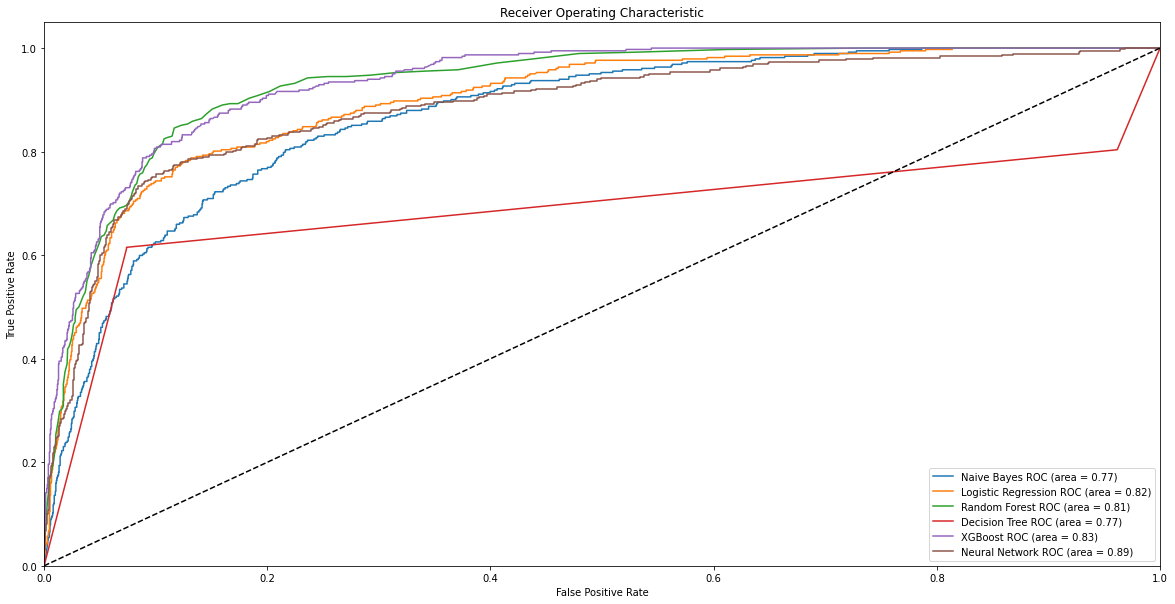

In [186]:
# plotting ROC curves


plt.figure(figsize=(20,10))
for m in models_rfe_smote:
  model = m['model']
  x_test = m['x_test']
  y_test = m['y_test']
  pred_proba = model.predict_proba(x_test.values)
  if m['label'] != 'Neural Network':
    pred_proba = pred_proba[:,1]
  # Compute False postive rate, and True positive rate
  fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
  # Calculate Area under the curve to display on the plot
  auc = roc_auc_score(y_test,model.predict(x_test.values))
  # Now, plot the computed values
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


PCA + SMOTE

In [187]:
x_train, x_test, y_train, y_test = train_test(temp_data, 0.2)

In [188]:
##Normalizing data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

xsc_train = sc.fit_transform(x_train)
xsc_test = sc.fit_transform(x_test)

In [189]:

# feature selection by Principal Component Analysis

from sklearn.decomposition import PCA

pca = PCA(n_components = None)

xpca_train = pca.fit_transform(xsc_train)
xpca_test = pca.transform(xsc_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Testing Accuracy :  0.7818329278183292
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      2084
           1       0.39      0.71      0.50       382

    accuracy                           0.78      2466
   macro avg       0.66      0.75      0.68      2466
weighted avg       0.85      0.78      0.80      2466

[[1656  428]
 [ 110  272]]
Sensitivity/tp_rate =  0.7120418848167539
Specificity/tn_rate =  0.7946257197696737
fp rate =  0.2053742802303263
fn rate =  0.2879581151832461
Confusion Matrix :


(0.7120418848167539,
 0.7946257197696737,
 0.2053742802303263,
 0.2879581151832461)

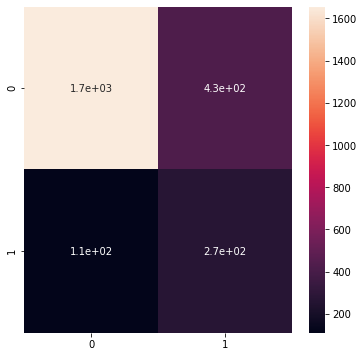

In [190]:
## NAIVE BAYES with PCA and SMOTE

models_pca_smote = []
gnb = GaussianNB()

x_train_pca, y_train_pca = smote_data(xpca_train, y_train)

y_pred = gnb.fit(x_train_pca, y_train_pca).predict(xpca_test)

models_pca_smote.append({'model' : gnb, 'label': 'Naive Bayes', 'x_test': xpca_test, 'y_test': y_test})

#print('Training Accuracy : ', gnb.score(x_train_pca, y_train_pca))

evaluate_model(y_test, y_pred)

Testing Accuracy :  0.8751013787510138
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2084
           1       0.57      0.79      0.66       382

    accuracy                           0.88      2466
   macro avg       0.76      0.84      0.79      2466
weighted avg       0.90      0.88      0.88      2466

[[1857  227]
 [  81  301]]
Sensitivity/tp_rate =  0.7879581151832461
Specificity/tn_rate =  0.8910748560460653
fp rate =  0.10892514395393474
fn rate =  0.21204188481675393
Confusion Matrix :


(0.7879581151832461,
 0.8910748560460653,
 0.10892514395393474,
 0.21204188481675393)

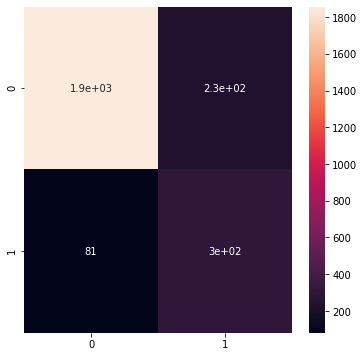

In [191]:
## Logistic Regression with PCA and SMOTE
model = LogisticRegression(max_iter=4000)

#x, y = smote_data(x_train, y_train)
#x_train_pca, y_train_pca = smote_data(xpca_train, y_train)
model.fit(x_train_pca, y_train_pca)

y_pred = model.predict(xpca_test)


models_pca_smote.append({'model' : model, 'label': 'Logistic Regression', 'x_test': xpca_test, 'y_test': y_test})

evaluate_model(y_test, y_pred)

Testing Accuracy :  0.8118410381184104
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      2084
           1       0.42      0.59      0.49       382

    accuracy                           0.81      2466
   macro avg       0.67      0.72      0.69      2466
weighted avg       0.84      0.81      0.82      2466

[[1778  306]
 [ 158  224]]
Sensitivity/tp_rate =  0.5863874345549738
Specificity/tn_rate =  0.8531669865642995
fp rate =  0.14683301343570057
fn rate =  0.41361256544502617
Confusion Matrix :


(0.5863874345549738,
 0.8531669865642995,
 0.14683301343570057,
 0.41361256544502617)

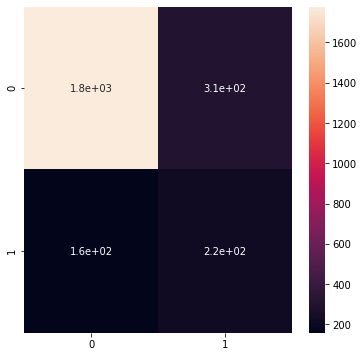

In [192]:
## Decision Tree with PCA and SMOTE
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train_pca, y_train_pca)

y_pred = model.predict(xpca_test)

models_pca_smote.append({'model' : model, 'label': 'Decision Tree', 'x_test': xpca_test, 'y_test': y_test})

evaluate_model(y_test, y_pred)

Testing Accuracy :  0.8759124087591241
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2084
           1       0.59      0.64      0.61       382

    accuracy                           0.88      2466
   macro avg       0.76      0.78      0.77      2466
weighted avg       0.88      0.88      0.88      2466

[[1916  168]
 [ 138  244]]
Sensitivity/tp_rate =  0.6387434554973822
Specificity/tn_rate =  0.9193857965451055
fp rate =  0.08061420345489444
fn rate =  0.3612565445026178
Confusion Matrix :


(0.6387434554973822,
 0.9193857965451055,
 0.08061420345489444,
 0.3612565445026178)

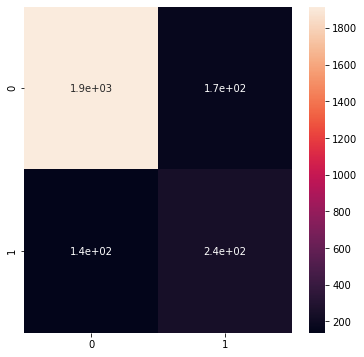

In [193]:
## Random Forests with PCA and SMOTE
model = RandomForestClassifier()
model.fit(x_train_pca, y_train_pca)

y_pred = model.predict(xpca_test)

models_pca_smote.append({'model' : model, 'label': 'Random Forest', 'x_test': xpca_test, 'y_test': y_test})
evaluate_model(y_test, y_pred)

Testing Accuracy :  0.8394160583941606
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      2084
           1       0.49      0.75      0.59       382

    accuracy                           0.84      2466
   macro avg       0.72      0.80      0.75      2466
weighted avg       0.88      0.84      0.85      2466

[[1782  302]
 [  94  288]]
Sensitivity/tp_rate =  0.7539267015706806
Specificity/tn_rate =  0.8550863723608445
fp rate =  0.14491362763915547
fn rate =  0.24607329842931938
Confusion Matrix :


(0.7539267015706806,
 0.8550863723608445,
 0.14491362763915547,
 0.24607329842931938)

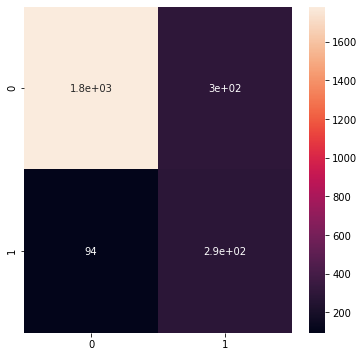

In [194]:
## XGBoost with PCA Data and SMOTE

from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = XGBClassifier()

model.fit(x_train_pca, y_train_pca)

models_pca_smote.append({'model' : model, 'label': 'XGBoost', 'x_test': xpca_test, 'y_test': y_test})

y_pred = model.predict(xpca_test)
evaluate_model(y_test, y_pred)

In [195]:
##NEURAL NETWORK with pca data and SMOTE

model = k.Sequential([
    k.layers.Dense(60, input_shape=(x_train_pca.shape[1],), activation=tf.nn.relu),
    k.layers.Dense(units=1, activation=tf.nn.sigmoid)
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 60)                1080      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 61        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


Testing Accuracy :  0.8698296836982968
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2084
           1       0.56      0.75      0.64       382

    accuracy                           0.87      2466
   macro avg       0.76      0.82      0.78      2466
weighted avg       0.89      0.87      0.88      2466

[[1857  227]
 [  94  288]]
Sensitivity/tp_rate =  0.7539267015706806
Specificity/tn_rate =  0.8910748560460653
fp rate =  0.10892514395393474
fn rate =  0.24607329842931938
Confusion Matrix :
Confusion Matrix :
78/78 [==============================] - 0s 893us/step - loss: 0.3375 - accuracy: 0.8698


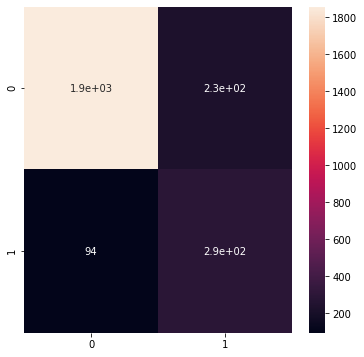

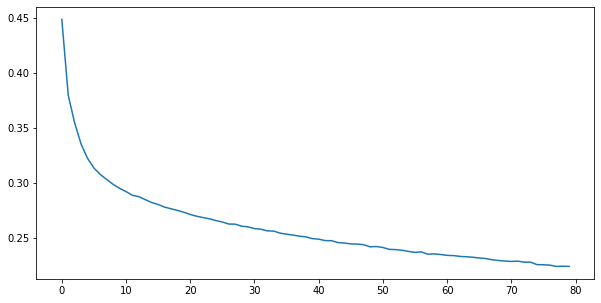

Training accuracy: 0.9151475429534912
Testing accuracy: 0.8698296546936035


In [196]:
stats = model.fit(x_train_pca, y_train_pca, epochs=80, validation_data=(xpca_test, y_test), verbose=False)
models_pca_smote.append({'model' : model, 'label': 'Neural Network', 'x_test': xpca_test, 'y_test': y_test})

y_pred = model.predict(xpca_test)
evaluate_model(y_test, y_pred.round())

print('Confusion Matrix :')

train_acc=model.evaluate(x_train_pca, y_train_pca, batch_size=1000)[1]
test_acc=model.evaluate(xpca_test, y_test, batch_size=1000)[1]
test_loss, test_accuracy = model.evaluate(xpca_test, y_test)
losses= stats.history['loss']
plt.figure(figsize=(10,5))
plt.plot(range(len(losses)), losses)
plt.show()
print("Training accuracy: %s" % train_acc)
print("Testing accuracy: %s" % test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



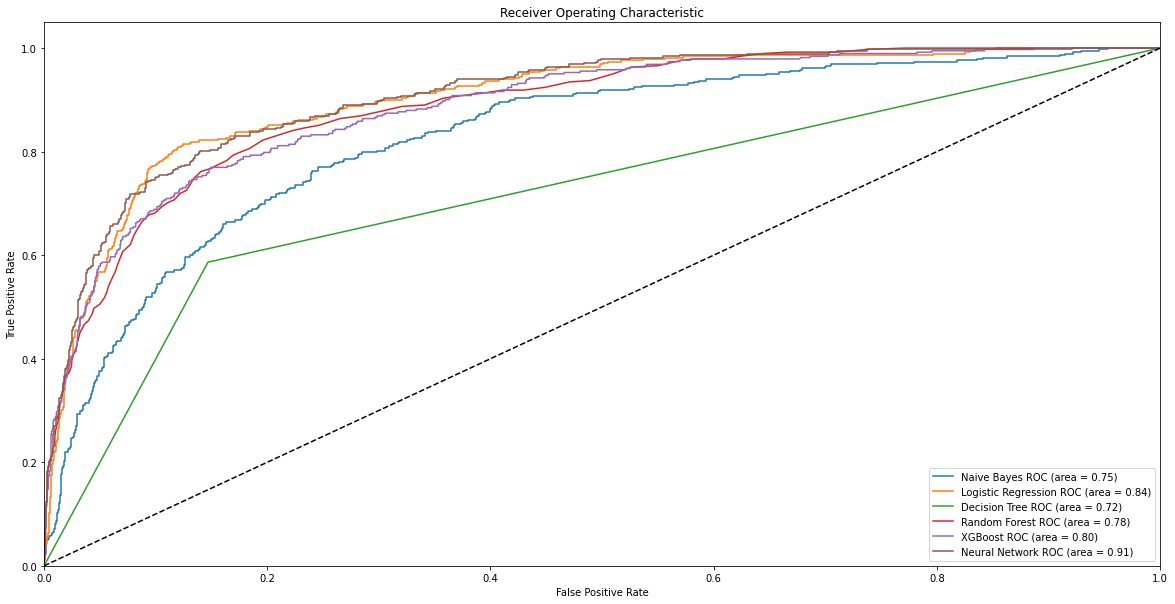

In [197]:
# plotting ROC curves for PCA w/smote data


plt.figure(figsize=(20,10))
for m in models_pca_smote:
  model = m['model']
  x_test = m['x_test']
  y_test = m['y_test']
  pred_proba = model.predict_proba(x_test)
  if m['label'] != 'Neural Network':
    pred_proba = pred_proba[:,1]
  # Compute False postive rate, and True positive rate
  fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
  # Calculate Area under the curve to display on the plot
  auc = roc_auc_score(y_test,model.predict(x_test))
  # Now, plot the computed values
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
